In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import HSBCAPI

In [2]:
from HSBCAPI import load_customer_info, load_transaction_history, load_CPI_holding, load_CPI_mapping, load_CPI, load_QDUT_holding, load_QDUT
from HSBCAPI import load_ISST_Summary, load_Cust_Purchase_Ind, load_DD_Acct_20170630
from HSBCAPI import load_QDUT_mapping, load_insurance_holding, load_insurance_mapping, load_insurance, load_TD_holding, load_TD_mapping, load_TD

In [3]:
#import all data
cust_info = load_customer_info()
transaction_history = load_transaction_history()
purchase_ind = load_Cust_Purchase_Ind()
ISST_Summary = load_ISST_Summary()
#Cust_Purchase_Ind = load_Cust_Purchase_Ind()
DDACCT = load_DD_Acct_20170630()
#Credit_Card_Txn = load_Credit_Card_Txn()
CPI_Input = load_CPI()
QDUT_Input = load_QDUT()
Insurance_Input = load_insurance()
TMD_Input = load_TD()

c:\users\hd626\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [4]:
#Pre-preprocessing
cust_info = cust_info.drop(["OccuDesc","BusDesc"], axis = 1)
cust_info = cust_info.reset_index()

In [5]:
transaction_history = transaction_history.replace("TMD PLACEMENT", "P")
transaction_history = transaction_history.replace("TMD WITHDRAWAL", "W") 

In [6]:
QDUT_Input = QDUT_Input.drop(["Product_Code", "Currency", "FUM_RCY", "FUM_LCY", "Y_M",
                             "Product_Type", "Investment_Currency", "NAV_YYYYMM"], axis = 1)
QDUT_Input["Holding"] = 1
QDUT_Input = QDUT_Input.drop_duplicates(subset = "Customer_id", keep = 'first')
cust_info.reset_index()
cust_info = cust_info.assign(HoldingQDUT=cust_info["Customer_id"].isin(QDUT_Input["Customer_id"]).astype(int))  

In [7]:
CPI_Input = CPI_Input.drop(["Product_Class", "Acct_id", "ACOpenDate", "Currency", "RCYEOD",
                             "LCYEOD", "MTDAVG", "Product_Code", "Investment_Currency",
                             "Start_Date", "Maturity_Date", "NAV"], axis = 1)
CPI_Input["Holding"] = 1
CPI_Input = CPI_Input.drop_duplicates(subset = "Customer_id", keep = 'first')
cust_info = cust_info.assign(HoldingCPI=cust_info["Customer_id"].isin(CPI_Input["Customer_id"]).astype(int))  

In [8]:
Insurance_Input = Insurance_Input.drop(["Product_Code", "Term", "Market_Value", "Insurer", "Needs"], axis = 1)
Insurance_Input["Holding"] = 1
Insurance_Input = Insurance_Input.drop_duplicates(subset = "Customer_id", keep = 'first')
cust_info = cust_info.assign(HoldingInsurance=cust_info["Customer_id"].isin(Insurance_Input["Customer_id"]).astype(int))  

In [9]:
TMD_Input = TMD_Input.drop(["Product_Class", "Acct_id", "ACOpenDate", "Currency", "RCYEOD",
                             "LCYEOD", "MTDAVG", "Term", "Startdate", "Duedate"], axis = 1)
TMD_Input["Holding"] = 1
TMD_Input = TMD_Input.drop_duplicates(subset = "Customer_id", keep = 'first')
cust_info = cust_info.assign(HoldingTMD=cust_info["Customer_id"].isin(TMD_Input["Customer_id"]).astype(int))  

In [10]:
def process(df):
    #split into categorical and non-categorical dataframes
    categorical_feature_mask = df.dtypes==object
    categorical_cols = df.columns[categorical_feature_mask].tolist()

    df_cat = df[categorical_cols]
    df = df.drop(categorical_cols, axis = 1)
    
    #deal with null values
    #fixing nulls for numerical categories
    df = df.fillna(df.mean())
    #fixing nulls for non-numerical categories
    df_cat = df_cat.fillna("")
    
    #convert categorical to onehot
    #Convert to one hot
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(handle_unknown='ignore')
    df_cat = enc.fit_transform(df_cat.astype(str))
    
    return df, df_cat

In [11]:
cust, cust_cat = process(cust_info)

In [12]:
t = cust.copy()

t = t.drop(["age", "FirstContactDay", "PBK_Ind", "OccuCode", "Salary", "Marital_Status", "Number_Children",
            "Education_Level", "Home_Ownership", "HoldingQDUT", "HoldingCPI", "HoldingInsurance", "HoldingTMD", "index"], axis=1)

purch = purchase_ind.copy()

purch.insert(13, "Output", 0) 

In [13]:
outputs = []
for index, row in purch.iterrows():
    for i in row:
        if i == 1:
            outputs.append(1)
            purch.at[index,'Output'] = 1
        else: purch.at[index,'Output'] = 0

In [14]:
len(outputs)

19553

In [15]:
ting1 = purch.drop(["Month 1", "Month 2", "Month 3", "Month 4", "Month 5", "Month 6", "Month 7", "Month 8",
                    "Month 9", "Month 10", "Month 11", "Month 12"], axis=1)

ting = ting1.rename(index=str, columns={"Customer_ID": "Customer_id"})

op = t.merge(ting, on="Customer_id")

In [16]:
#drops Customer_id index since it would bias the data if included in the prediction
op = op.drop(["Customer_id"], axis=1)

#turn pandas dataframe into numpy matrix
op = op.values

#converts the sparse matrix for the one hot vectors into a dense matrix
cust_cat = cust_cat.todense()

#drops Customer_id index since it would bias the data if included in the prediction
cust_info = cust.drop(columns = ["Customer_id"])

#turn pandas dataframe into numpy matrix
cust_info = cust_info.values

#put all matrices into one
inputs = np.hstack((cust_info, cust_cat, op))

In [17]:
#at this point, cust_info should have all the data we consolidated in numpy matrix form minus customer ids
inputs.shape

(300039, 338)

In [18]:
op.shape

(300039, 1)

In [19]:
X = torch.tensor(inputs, dtype=torch.float)
y = torch.tensor(op, dtype=torch.float)

In [20]:
def get_correct_and_accuracy(y_pred, y):
    # y_pred is the nxC prediction scores
    # give the number of correct and the accuracy
    n = y.shape[0]
    # find the prediction class label
    _ ,pred_class = y_pred.max(dim=1)
    correct = (pred_class == y).sum().item()
    return correct ,correct/n

In [54]:
class MLP(nn.Module):
    ## a very simple MLP model
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 150)
        self.fc2 = nn.Linear(150, 20)
        self.fc3 = nn.Linear(20, output_dim)
        
        # in order to put all of the parameters into a list you have to use nn.Module([]) bc you cant use a normal python list
#         nn.Module([])
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [81]:
validation_count = 15000
train_count = X.shape[0]-validation_count
X_train = X[:train_count]
y_train = y[:train_count]
X_val = X[train_count:]
y_val = y[train_count:]
X_test = X
y_test = y

In [85]:
mlp = MLP(338, 2)
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

n_iteration = 15
batch_size = 400
n_train_data = X_train.shape[0]
n_batch = int(np.ceil(n_train_data/batch_size))

X_train_tensor = Tensor(X_train).reshape(n_train_data, -1)
X_val_tensor = Tensor(X_val).reshape(validation_count, -1)
X_test_tensor = Tensor(X_test).reshape(300039, -1)

y_train_tensor = Tensor(y_train).long().reshape(-1)
y_val_tensor = Tensor(y_val).long().reshape(-1)
y_test_tensor = Tensor(y_test).long().reshape(-1)

In [86]:
X_val_tensor.shape

torch.Size([15000, 338])

In [87]:
train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)
for i in range(n_iteration):
    # first get a minibatch of data
    train_loss_all_batch = 0
    train_correct = 0
    for j in range(n_batch):
        batch_start_index = j*batch_size

        X_batch = X_train_tensor[batch_start_index:batch_start_index+batch_size]
        
        y_pred_batch = mlp.forward(X_batch)
        
        y_batch = y_train_tensor[batch_start_index:batch_start_index+batch_size]
        
        train_loss = criterion(y_pred_batch, y_batch)
        
        train_loss_all_batch += train_loss.item()
        
        optimizer.zero_grad()
        
        train_loss.backward()
        
        optimizer.step()
        
        train_correct_batch, _ = get_correct_and_accuracy(y_pred_batch, y_batch)
        train_correct += train_correct_batch
        
    ## logging training information    
    ave_train_loss = train_loss_all_batch / n_batch
    train_accu = train_correct / n_train_data
    
    # compute validation loss and accuracy
    y_val_pred = mlp(X_val_tensor)
    val_loss = criterion(y_val_pred, y_val_tensor)
    val_correct, val_accu = get_correct_and_accuracy(y_val_pred, y_val_tensor)
    
    print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f" 
          %(i ,ave_train_loss, train_accu, val_loss, val_accu)) 
    
    ## add to the logs so that we can use them later for plotting
    train_loss_list[i] = ave_train_loss
    train_accu_list[i] = train_accu
    val_loss_list[i] = val_loss.item()
    val_accu_list[i] = val_accu

Iter 0 ,Train loss: 1093.606, Train acc: 0.989, Val loss: 486.278, Val acc: 0.995
Iter 1 ,Train loss: 326.062, Train acc: 0.990, Val loss: 128.923, Val acc: 0.995
Iter 2 ,Train loss: 174.170, Train acc: 0.991, Val loss: 27.617, Val acc: 0.995
Iter 3 ,Train loss: 26.728, Train acc: 0.992, Val loss: 0.258, Val acc: 0.995
Iter 4 ,Train loss: 0.653, Train acc: 0.995, Val loss: 0.097, Val acc: 0.995
Iter 5 ,Train loss: 0.693, Train acc: 0.995, Val loss: 0.060, Val acc: 0.995
Iter 6 ,Train loss: 0.450, Train acc: 0.995, Val loss: 0.046, Val acc: 0.995
Iter 7 ,Train loss: 0.828, Train acc: 0.995, Val loss: 0.039, Val acc: 0.995
Iter 8 ,Train loss: 0.175, Train acc: 0.995, Val loss: 0.036, Val acc: 0.995
Iter 9 ,Train loss: 0.033, Train acc: 0.995, Val loss: 0.035, Val acc: 0.995
Iter 10 ,Train loss: 0.032, Train acc: 0.995, Val loss: 0.034, Val acc: 0.995
Iter 11 ,Train loss: 0.031, Train acc: 0.995, Val loss: 0.033, Val acc: 0.995
Iter 12 ,Train loss: 0.031, Train acc: 0.995, Val loss: 0.033

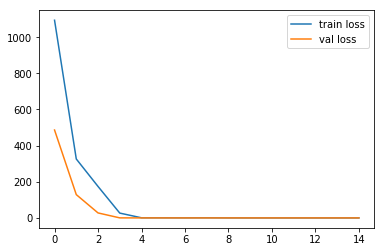

In [88]:
## plot training loss versus validation loss
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

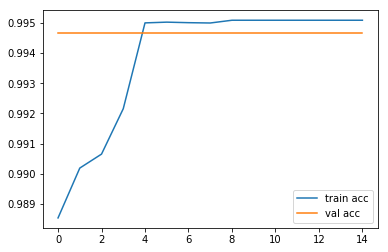

In [89]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()

In [ ]:
test_pred = mlp.forward(X_test_tensor)
test_correct, test_acc = get_correct_and_accuracy(test_pred, y_test_tensor)
print("Test accuracy:", (test_acc))